In [291]:
from cProfile import label
from pickletools import optimize
from random import sample
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# ネットワークや損失関数の定義

DMMのネットワークを定義する

In [292]:
class StructuredDMM(nn.Module):
    def __init__(self, z_dim=2, input_dim=2, lay_dim=2**6, n_layer=4, rnn_dim=600):
        super().__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.lay_dim = lay_dim
        self.n_layer = n_layer

        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()    
        self.relu = nn.ReLU() 

        # Combiner
        self.com_lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.com_lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.com_lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)

        # Emitter
        self.em_lin_z_to_hidden = nn.Linear(z_dim, lay_dim)
        self.em_lin_hidden_to_hidden = nn.Linear(lay_dim, lay_dim)
        self.em_lin_hidden_to_input = nn.Linear(lay_dim, input_dim)

        # GatedTransition
        self.gate_lin_gate_z_to_hidden = nn.Linear(z_dim, lay_dim)
        self.gate_lin_gate_hidden_to_z = nn.Linear(lay_dim, z_dim)
        self.gate_lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, lay_dim)
        self.gate_lin_proposed_mean_hidden_to_z = nn.Linear(lay_dim, z_dim)
        self.gate_lin_sig = nn.Linear(z_dim, z_dim)
        self.gate_lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of the lin_z_to_loc
        # so that it's starts out as the identity function
        self.gate_lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.gate_lin_z_to_loc.bias.data = torch.zeros(z_dim)

        num_layers=1
        rnn_dropout_rate = 0.0 if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(
            input_size = input_dim,
            hidden_size = rnn_dim,
            nonlinearity = "relu",
            batch_first = True,
            bidirectional=False,
            num_layers=num_layers,
            dropout=rnn_dropout_rate,
        )

        # initial values of structured network
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1,1, rnn_dim))
        # initial values of DMM
        # self.z_0 = nn.Parameter(torch.zeros(z_dim))

    def combiner(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """

        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.com_lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.com_lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.com_lin_hidden_to_scale(h_combined))

        return loc, scale

    def trans(self, z_t_1):
        _gate = self.relu(self.gate_lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.gate_lin_gate_hidden_to_z(_gate))
        # compute proposed mean
        _proposed_mean = self.relu(self.gate_lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.gate_lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.gate_lin_z_to_loc(z_t_1) + gate * proposed_mean       
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.gate_lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale      

    def emitter(self, z_t):
        h1 = self.relu(self.em_lin_z_to_hidden(z_t))
        h2 = self.relu(self.em_lin_hidden_to_hidden(h1))
        out = self.em_lin_hidden_to_input(h2)
        return out

    def forward(self, mini_batch):
        T_max = mini_batch.size(1)

        xhist = []
        zhist = []
        z_q_hist = []

        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_q_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))

        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(
            1, mini_batch.size(0), self.rnn.hidden_size
        ).contiguous()
        mini_batch_reversed = mini_batch.flip(dims=(1,))
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        # reverse the time-ordering in the hidden state and un-pack it
        rnn_output = rnn_output.flip(dims=(1,))

        for t in range(1, T_max+1):
            z_q_loc, z_q_scale = self.combiner(z_q_prev, rnn_output[:,t-1,:])
            e = Variable(torch.zeros(z_q_loc.data.size()).normal_())
            z_q = z_q_loc + z_q_scale * e

            # inference networkから得られたz_q_prev, z_qをgenerative networkに使う
            z_loc, z_scale = self.trans(z_q_prev)
            e = Variable(torch.zeros(z_loc.data.size()).normal_())
            z = z_loc + z_scale * e
            x = self.emitter(z_q)
            
            xhist.append(x)
            zhist.append(z)
            z_q_hist.append(z_q)

            z_q_prev = z_q

        return torch.stack(xhist,dim=1), torch.stack(zhist, dim=1), torch.stack(z_q_hist, dim=1), rnn_output

    def generate(self, sample_num, seq_len):
        xhist = []
        zhist = []

        z_prev = self.z_q_0.expand(sample_num, self.z_q_0.size(0))

        for t in range(seq_len):
            z_loc, z_scale = self.trans(z_prev)
            e = Variable(torch.zeros(z_loc.data.size()).normal_())
            z = z_loc + z_scale * e
            x = self.emitter(z)

            xhist.append(x)
            zhist.append(z)

            z_prev = z
        
        return torch.stack(xhist,dim=1), torch.stack(zhist, dim=1)

学習データを吐き出す関数を作る．
以下の二つの関数はどちらも二次元の時系列データを生成する関数．
`sample_generator2`は二次元平面上で円を左回りに描く軌道を生成する（詳細は実験結果を参照）．

In [293]:
def sample_generator(batch_num, seq_len): # seq_lenは時系列の長さ
    return torch.tensor([[[i+j, i+j] for i in range(seq_len)] for j in range(batch_num)]).float()

def sample_generator2(batch_num, seq_len): # seq_lenは時系列の長さ
    dim = 2
    xdata = np.zeros((batch_num,seq_len,dim))
    for j in range(batch_num):
        for i in range(seq_len):
            xdata[j,i,0] = 0.1*np.cos(2*np.pi/seq_len*i) + 0.01*np.random.randn()
            xdata[j,i,1] = 0.1*np.sin(2*np.pi/seq_len*i) + 0.01*np.random.randn()
    return torch.tensor(xdata).float()

def sample_generator3(batch_num, seq_len): # seq_lenは時系列の長さ
    dim = 2
    xdata = np.zeros((batch_num,seq_len,dim))
    for j in range(batch_num):
        for i in range(seq_len):
            xdata[j,i,0] = i
            xdata[j,i,1] = 0.1*np.sin(2*np.pi/seq_len*i) + 0.01*np.random.randn()
    return torch.tensor(xdata).float()

def sample_generator4(batch_num, seq_len): # seq_lenは時系列の長さ
    dim = 2
    xdata = np.zeros((batch_num,seq_len,dim))
    for j in range(batch_num):
        for i in range(seq_len):
            xdata[j,i,0] = 0.1*(i+1)*np.cos(6*np.pi/seq_len*i) + 0.1*np.random.randn()
            xdata[j,i,1] = 0.1*(i+1)*np.sin(6*np.pi/seq_len*i) + 0.1*np.random.randn()
    return torch.tensor(xdata).float()

def line_with_gaussian_noise(batch_num, seq_len): # seq_lenは時系列の長さ
    return torch.tensor([[[1.0*i + torch.randn(1)[0]] for i in range(seq_len)] for j in range(batch_num)]).float()


学習データの描画

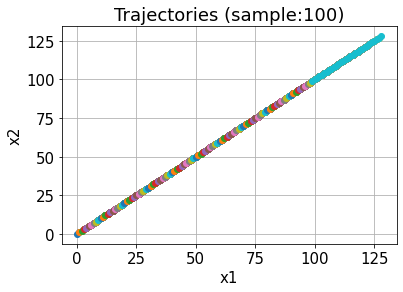

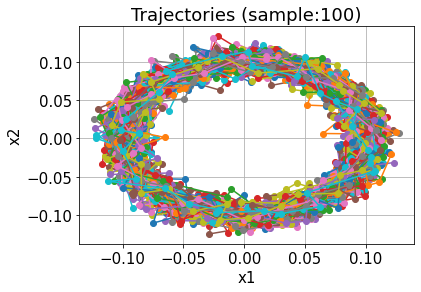

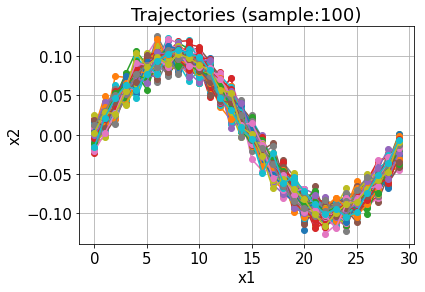

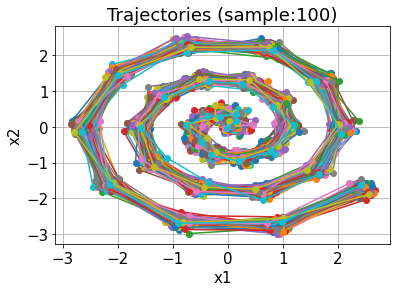

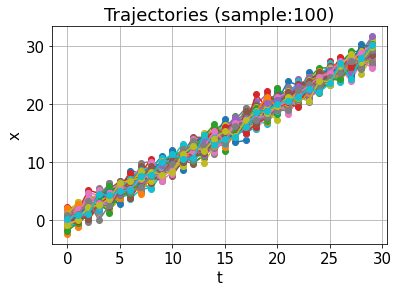

In [294]:
training_data = [sample_generator, sample_generator2, sample_generator3, sample_generator4, line_with_gaussian_noise]
training_data_dim = [2,2,2,2,1]

batch_num = 100
seq_len = 30

for i,data in enumerate(training_data):
    xdata = data(batch_num, seq_len)
    xdata = xdata = xdata.data.cpu().numpy()
    if training_data_dim[i] == 1:
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o')
        plt.grid()
        plt.xlabel("t") # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel("x")
        plt.title("Trajectories (" +"sample:" + str(xdata.shape[0]) + ")")
        plt.show()
    elif training_data_dim[i] == 2:
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o')
        plt.grid()
        plt.xlabel("x1") # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel("x2")
        plt.title("Trajectories (" +"sample:" + str(xdata.shape[0]) + ")")
        plt.show()

Wasserstein distanceとMMDから損失関数を計算する関数群を定義

In [295]:
# 参考：https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
def compute_kernel(x, y):
    # データのテンソルが(バッチ数)x(時間の長さ)x(xの空間の次元)の順に並んだテンソルであるとする
    x_size = x.size(0)
    y_size = y.size(0)
    
    # 時系列の時間ステップ数はxとyで同じとする
    seq_len = x.size(1)

    # x と yの次元は同じとする．
    dim = x.size(2)

    x = x.unsqueeze(1) # (x_size, 1, seq_len, dim)
    y = y.unsqueeze(0) # (1, y_size, seq_len, dim)

    tiled_x = x.expand(x_size, y_size, seq_len, dim)
    tiled_y = y.expand(x_size, y_size, seq_len, dim)

    kernel_input = (tiled_x - tiled_y).pow(2).mean((2,3))
    return torch.exp(-kernel_input)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()

lam = 2000.0
def Wloss(x, x_m, z, z_tilde): # x, x_m は出力変数（時系列）．z, z_tildeは隠れ変数（時系列）
    num = x.size(0)
    Wloss = torch.square(x-x_m).sum()/float(num)
    MMD = compute_mmd(z,z_tilde)
    return Wloss + lam*MMD, Wloss, MMD

# 学習の処理
これ以降は実際に学習を行うための処理

In [296]:
lr=0.001
dmm = StructuredDMM(z_dim=1, input_dim=1, lay_dim=2**6, n_layer=4, rnn_dim=600)
optimizer = optim.Adam(dmm.parameters(), lr=lr)

In [297]:
training_data = [sample_generator, sample_generator2, sample_generator3, sample_generator4, line_with_gaussian_noise]
training_data_number = 4  # 訓練データの選択
epochs = 5000       # epoch数
length = 6         # データの長さ
loss_hist = []      # 損失関数の履歴
wloss_hist = []     # 損失関数の中のWasserstein距離の履歴
mmd_hist = []       # 損失関数の中のMMDの値の履歴

学習のループを回す

円
epoch = 5000
lam = 20.0
alpha = 0.03
length = 10
batch_num = 2**6 
z_dim = 1

直線
epoch = 5000
lam = 40.0
alpha = 0.03
length = 6
batch_num = 2**6
z_dim = 2

渦巻(失敗)
epoch = 5000
lam = 20.0
alpha = 0.03
length = 30
batch_num = 2**6
z_dim = 2

渦巻(成功)
epoch = 5000
lam = 20.0
alpha = 0.03
length = 30
batch_num = 2**6
z_dim = 3

In [298]:
# 学習ループ
for i in range(epochs):
    optimizer.zero_grad()
    train_data = training_data[training_data_number](batch_num = 2**6, seq_len = length)
    x_gen, z, zq, _ = dmm(train_data)

    loss_val, wassdis, MMD = Wloss(train_data, x_gen, z, zq)
    loss_val.backward()
    optimizer.step()

    loss_hist.append(loss_val.data.cpu().numpy().item())
    wloss_hist.append(wassdis.data.cpu().numpy().item())
    mmd_hist.append(MMD.data.cpu().numpy().item())

    print('%5d: %.5f\t %.5f\t %.5f' % (i, loss_val.data.cpu().numpy(), wassdis.data.cpu().numpy(), MMD.data.cpu().numpy()), end='\r')

損失関数の時間変化をプロットする

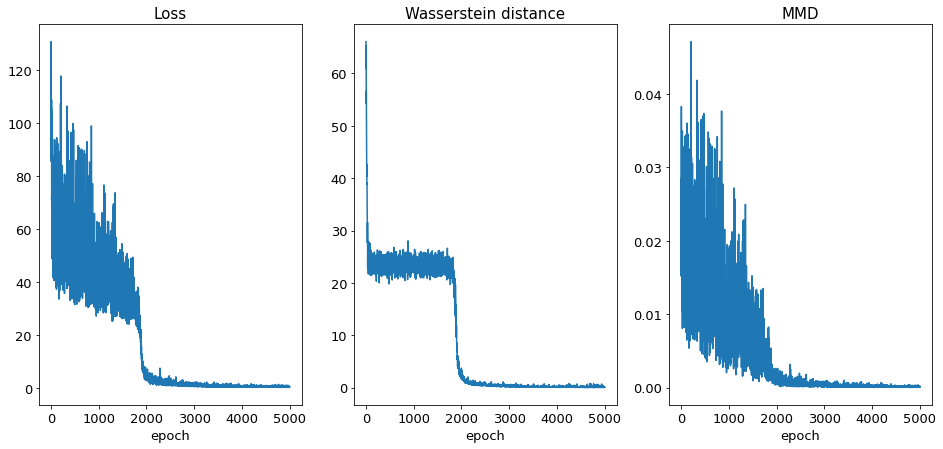

In [299]:
name = "1_1"
place = "Xline/"
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
# import matplotlib
# del matplotlib.font_manager.weight_dict['roman']
# matplotlib.font_manager._rebuild()
# plt.rcParams['font.family'] = 'Roman' #全体のフォントを設定
# loss function
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")

plt.savefig(place + name + "_loss.pdf")
plt.show()
# plt.close()

Reconstructionと生成を行う

In [300]:
# %% Data for Reconstruction
test_data = training_data[training_data_number](10,length)
with torch.no_grad():
    # Reconstruction
    xreconstructed, zreconstructed, zreconstructed_q, _ = dmm(test_data)
    # 生成
    xgenerated, zgenerated = dmm.generate(10, train_data.size(1))
    
np.save("Array/" + name + "_loss", loss_hist)
np.save("Array/" + name + "_wloss", wloss_hist)
np.save("Array/" + name + "_mmd", mmd_hist)
np.save("Array/" + name + "_hyper", np.array([lam, lr]))
np.save("Array/" + name + "_test", test_data)
np.save("Array/" + name + "_xreconstructed", xreconstructed)
np.save("Array/" + name + "_zreconstructed", zreconstructed)
np.save("Array/" + name + "_zreconstructed_q", zreconstructed_q)
np.save("Array/" + name + "_zgenerated", zgenerated)
np.save("Array/" + name + "_xgenerated", xgenerated)

データを可視化するための関数を用意する

In [301]:
# cmap = plt.get_cmap("tab20")
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place="NO"):
    xdata = xdata.data.cpu().numpy()

    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(4,7))
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$")
        plt.ylabel(r"$x$")
        y_lim = [-1.5, 6.5]
        plt.ylim(y_lim)
        # plt.title(r"$x(t)$ (" + type_of_data +", sample:" + str(xdata.shape[0]) + ")")
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

学習データ，Reconstructionのデータ，生成データを可視化する．
学習データの軌道が(x1, x2) = (0.1,0)から左回りに円をたどるような軌道を描いている．
それに対して，Reconstructionデータも生成データも左回りに円をたどるような軌道となっていることがわかる．
分散が小さいなどの特徴が見られるが，ほぼ学習データの特徴を捉えて，時系列データの生成ができている．

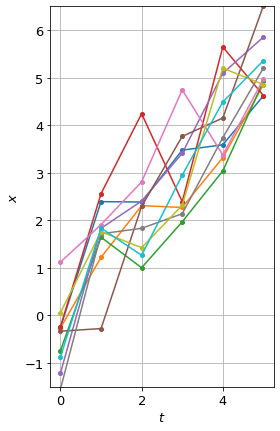

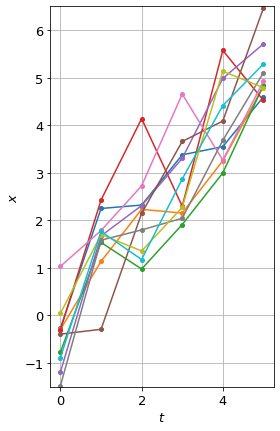

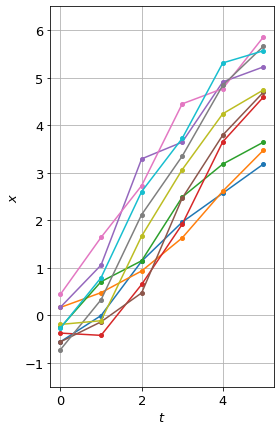

In [302]:

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

本来，zは高次元とするので可視化は難しいが，上の設定ではzも2次元にしているため，xと同様にプロットして挙動を確かめる．
x(t)がxの空間で左回りに円を描くのに対して，latent variableの空間では，z(0)が特定の点付近に集中し，tが増加するにつれて，z(t)は第一成分，第二成分ともに一次関数のように変化する傾向がある．
これは，x(t)の空間のx(t)の時間変化の特徴をz(t)の空間で獲得できていることを示している．

In [303]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place = "NO"):
    zdata = zdata.data.cpu().numpy()

    FontSize = 13
    plt.rcParams["font.size"] = FontSize

    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()


    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        # x_lim = [-1.0, 1.0] 
        # y_lim = [-1.0, 1.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # plt.title("Trajectories of " + type_of_data)

        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        # plt.ylim(x_lim)
        # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_2$", size= 16)
        # plt.ylim(y_lim)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

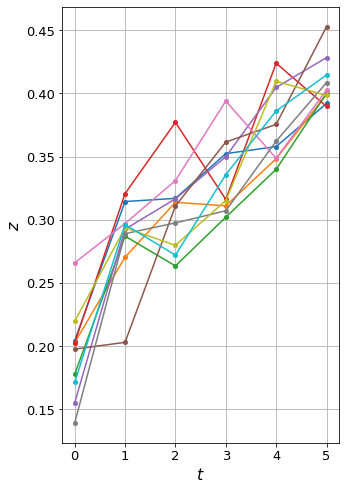

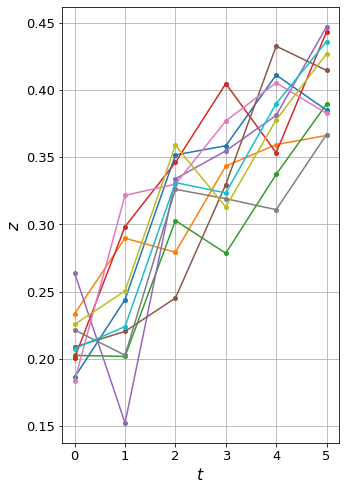

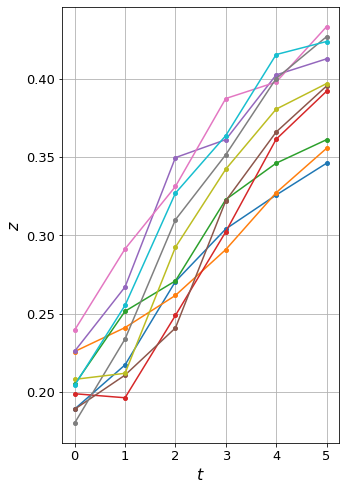

In [304]:
# name = "NO"
plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

In [305]:
# %% Data for Reconstruction
with torch.no_grad():
    xxgenerated, zzgenerated = dmm.generate(1000, train_data.size(1))

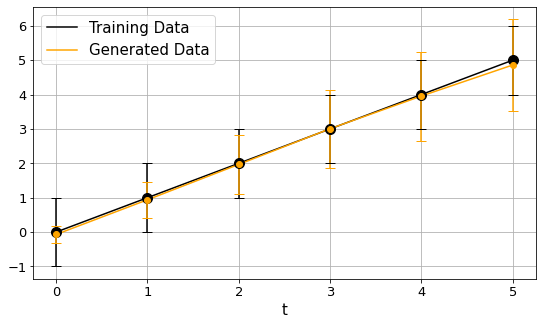

In [306]:
# calc av of gene
def cal_av(gene):
    N = gene.size(0)
    return gene.sum(dim=0) / N

# cal sigma of gene
def cal_sg(gene):
    N = gene.size(0)
    av = cal_av(gene)
    av = av.expand(N, gene.size(1), gene.size(2))
    return ((gene-av)*(gene-av)).sum(dim=0) / N

gene_av = cal_av(xxgenerated)
gene_sg = cal_sg(xxgenerated)
training_av = torch.tensor([[i * 1.0] for i in range(length)])
training_sg = torch.tensor([[1.0] for i in range(length)])

np.save("Array/" + name + "_av", gene_av)
np.save("Array/" + name + "_sg", gene_sg)
# for dat in generations[number]:
#     plt.plot(dat.detach().numpy())

FS = 15
fig = plt.figure(figsize=(9, 5))
# plt.title("Sin Curves")
plt.xlabel("t", fontsize=15)
# plt.ylabel("y", fontsize=FS)
plt.rcParams["font.size"] = FS
training_color = "black"
plt.errorbar(np.arange(0,length), training_av.detach().numpy(), yerr = training_sg.detach().numpy(), capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='black')
plt.plot(np.arange(0,length), training_av.detach().numpy(),color='black', label="Training Data")
gene_color = "orange"
plt.errorbar(np.arange(0,length), gene_av.detach().numpy(), yerr = gene_sg.detach().numpy(), capsize=5, fmt='o', markersize=6, ecolor=gene_color, markeredgecolor = gene_color, color=gene_color)
plt.plot(np.arange(0,length), gene_av.detach().numpy(),color=gene_color, label="Generated Data")
# plt.xticks([0,1,2,3], [0,1,2,3], size=15)
# plt.yticks([0, 3, 6, 9], [0, 3, 6, 9],size=15)
plt.grid()
plt.legend()
plt.savefig(place + name +  "_result.pdf")